In [24]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
df_customers  = pd.read_csv("Customers.csv")
df_products   = pd.read_csv("Products.csv")
df_transactions = pd.read_csv("Transactions.csv")


In [26]:

merged_df1 = pd.merge(df_transactions, df_customers, on='CustomerID', how='left')


merged_df = pd.merge(merged_df1, df_products, on='ProductID', how='left')


merged_df.head(5)



,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [27]:
merged_df1 = merged_df.drop(columns=['ProductName','TransactionID','Price_x','Price_y','CustomerName'])

In [28]:
# merged_df1.info()

In [29]:

print(merged_df1.shape)
merged_df1.head(5)

(1000, 8)


,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Region,SignupDate,Category
0,C0199,P067,2024-08-25 12:38:23,1,300.68,Europe,2022-12-03,Electronics
1,C0146,P067,2024-05-27 22:23:54,1,300.68,Asia,2024-09-04,Electronics
2,C0127,P067,2024-04-25 07:38:55,1,300.68,Europe,2024-04-04,Electronics
3,C0087,P067,2024-03-26 22:55:37,2,601.36,South America,2024-04-11,Electronics
4,C0070,P067,2024-03-21 15:10:10,3,902.04,Europe,2022-03-15,Electronics


In [30]:
merged_df1['SignupMonth'] = pd.to_datetime(merged_df1['SignupDate']).dt.month

merged_df1['TransactionMonth'] = pd.to_datetime(merged_df1['TransactionDate']).dt.month

merged_df1 = merged_df1.drop(columns=['TransactionDate','SignupDate'])

merged_df1.head(5)

,CustomerID,ProductID,Quantity,TotalValue,Region,Category,SignupMonth,TransactionMonth
0,C0199,P067,1,300.68,Europe,Electronics,12,8
1,C0146,P067,1,300.68,Asia,Electronics,9,5
2,C0127,P067,1,300.68,Europe,Electronics,4,4
3,C0087,P067,2,601.36,South America,Electronics,4,3
4,C0070,P067,3,902.04,Europe,Electronics,3,3


In [31]:
customer_features = merged_df1.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Region': lambda x: x.mode()[0],  # Get most frequent region
    'SignupMonth': 'first',
    'TransactionMonth': lambda x: x.mode()[0],
    'ProductID' : lambda x: x.mode()[0],
    'Category' : lambda x: x.mode()[0]
}).reset_index()

In [32]:
print(customer_features.shape)
print(merged_df1.shape)

(199, 8)
(1000, 8)


In [33]:
customer_features.head(5)

,CustomerID,TotalValue,Quantity,Region,SignupMonth,TransactionMonth,ProductID,Category
0,C0001,3354.52,12,South America,7,1,P022,Electronics
1,C0002,1862.74,10,Asia,2,2,P004,Clothing
2,C0003,2725.38,14,South America,3,6,P002,Home Decor
3,C0004,5354.88,23,South America,10,12,P008,Books
4,C0005,2034.24,7,Asia,8,3,P012,Electronics


In [34]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()

# Encode 'Region'
customer_features['Region_Encoded'] = le.fit_transform(customer_features['Region'])

# Encode 'Category'
customer_features['Category_Encoded'] = le.fit_transform(customer_features['Category'])

# Encode 'ProductID'
customer_features['ProductID_Encoded'] = le.fit_transform(customer_features['ProductID'])


In [35]:
customer_features = customer_features.drop(columns=['Region','ProductID','Category'])
customer_features


,CustomerID,TotalValue,Quantity,SignupMonth,TransactionMonth,Region_Encoded,Category_Encoded,ProductID_Encoded
0,C0001,3354.52,12,7,1,3,2,21
1,C0002,1862.74,10,2,2,0,1,3
2,C0003,2725.38,14,3,6,3,3,1
3,C0004,5354.88,23,10,12,3,0,7
4,C0005,2034.24,7,8,3,0,2,11
...,...,...,...,...,...,...,...,...
194,C0196,4982.88,12,6,8,1,3,62
195,C0197,1928.65,9,3,1,1,2,12
196,C0198,931.83,3,2,9,1,1,54
197,C0199,1979.28,9,12,8,1,2,7


In [36]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

scaler = MinMaxScaler()
customer_features[['TotalValue', 'Quantity','SignupMonth','TransactionMonth','Region_Encoded','Category_Encoded','ProductID_Encoded']] = scaler.fit_transform(customer_features[['TotalValue', 'Quantity','SignupMonth','TransactionMonth','Region_Encoded','Category_Encoded','ProductID_Encoded']])


In [37]:
feature_cols = ['TotalValue', 'Quantity','SignupMonth','TransactionMonth','Region_Encoded','Category_Encoded','ProductID_Encoded']
X = customer_features[feature_cols]


In [38]:
db_scores = []
sil_scores = []
clusters_range = range(2, 11)

for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    
    # Calculate metrics
    db_index = davies_bouldin_score(X, labels)
    sil_score = silhouette_score(X, labels)
    
    db_scores.append(db_index)
    sil_scores.append(sil_score)

c:\Users\nis44\anaconda3\NLP\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nis44\anaconda3\NLP\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nis44\anaconda3\NLP\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nis44\anaconda3\NLP\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memor

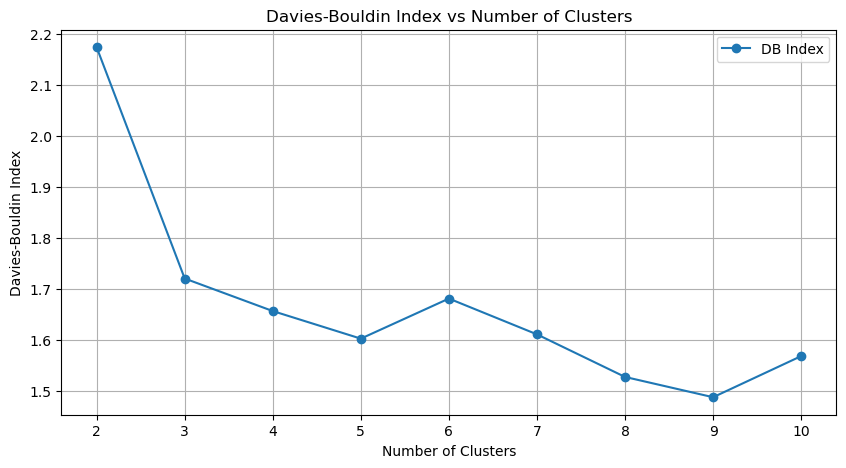

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot Davies-Bouldin Index
plt.figure(figsize=(10, 5))
plt.plot(clusters_range, db_scores, marker='o', label='DB Index')
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.legend()
plt.grid()
plt.show()

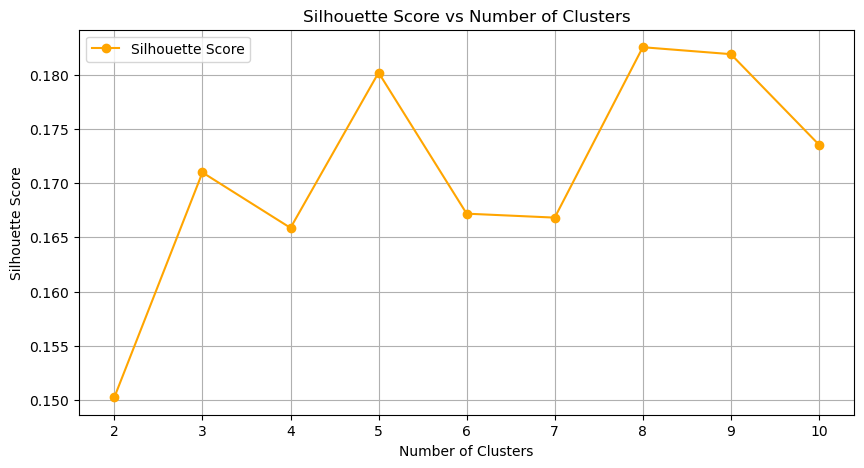

In [40]:
# Plot Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(clusters_range, sil_scores, marker='o', label='Silhouette Score', color='orange')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.legend()
plt.grid()
plt.show()

In [41]:
import numpy as np


optimal_clusters = clusters_range[np.argmin(db_scores)]
print(f"Optimal Number of Clusters: {optimal_clusters}")


Optimal Number of Clusters: 9


In [42]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(X)

c:\Users\nis44\anaconda3\NLP\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [43]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(X)


final_db_index = davies_bouldin_score(X, customer_features['Cluster'])
final_silhouette = silhouette_score(X, customer_features['Cluster'])

print(f"Final Davies-Bouldin Index: {final_db_index}")
print(f"Final Silhouette Score: {final_silhouette}")

Final Davies-Bouldin Index: 1.4883437690487145
Final Silhouette Score: 0.1818948970468092


c:\Users\nis44\anaconda3\NLP\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
